# Исследование текстов

<h1>Содержание<span class='tocSkip'></span></h1>

* [1 Подготовка](#my_section_1) <a id='content_1'></a>
  * [1.1 Ознакомление](#my_section_2) <a id='content_2'></a>
    * [1.1.1 head, info](#my_section_3) <a id='content_3'></a>
    * [1.1.2 Распределение классов](#my_section_4) <a id='content_4'></a>
    * [1.1.3 Вывод](#my_section_5) <a id='content_5'></a>
  * [1.2 Упрощение текста](#my_section_6) <a id='content_6'></a>
    * [1.2.1 Токенизация](#my_section_7) <a id='content_7'></a>
    * [1.2.2 Лемматизация](#my_section_8) <a id='content_8'></a>
    * [1.2.3 Частотный анализ](#my_section_9) <a id='content_9'></a>
  * [1.3 Подготовка признаков](#my_section_10) <a id='content_10'></a>
    * [1.3.1 Разделение на выборки](#my_section_11) <a id='content_11'></a>
    * [1.3.2 Ребаланс/Upsampling](#my_section_12) <a id='content_12'></a>
    * [1.3.3 TF_IDF](#my_section_13) <a id='content_13'></a>
  * [1.4 Заключение](#my_section_14) <a id='content_14'></a>
* [2 Обучение](#my_section_15) <a id='content_15'></a>
  * [2.1 LogisticRegression](#my_section_16) <a id='content_16'></a>
    * [2.1.1 Upsample](#my_section_17) <a id='content_17'></a>
    * [2.1.2 Balanced](#my_section_18) <a id='content_18'></a>
    * [2.1.3 GridSearchCV + Pipeline](#my_section_19) <a id='content_19'></a>
  * [2.2 CatBoostClassifier](#my_section_20) <a id='content_20'></a>
    * [2.2.1  GridSearchCV + Pipeline](#my_section_21) <a id='content_21'></a>
  * [2.3 Заключение](#my_section_22) <a id='content_22'></a>
* [3 Тестирование](#my_section_23) <a id='content_23'></a>
* [4 Выводы](#my_section_24) <a id='content_24'></a>


**Задача:**<br/>
Обучить модель классифицировать комментарии на позитивные и негативные.

**Примечание:**<br/>
Модель измеряется метрикой качества F1, её точность должна быть не меньше 0.75

**Предварительные этапы:**<br/>
1. Загрузка данных;
2. Подготовка; 
3. Обучение моделей;
4. Выводы.

**Описание данных**<br/>
В распоряжении набор данных с разметкой о токсичности правок.
- данные находятся в файле toxic_comments.csv
- столбец text в нём содержит текст комментария, а toxic — целевой признак.


<a id='my_section_1'></a>
## [Подготовка](#content_1)

Произведём импорт основных библиотек и модулей

In [1]:
#!pip install ipywidgets

In [2]:
#pip install nltk

In [3]:
#pip install wordcloud

In [4]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from catboost import CatBoostClassifier

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import (wordnet,
                         stopwords as nltk_stopwords)

import time
from tqdm import notebook, tqdm

from wordcloud import WordCloud

In [5]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tolge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tolge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tolge\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tolge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Определим функцию для загрузки файла

In [6]:
def download_file(name):
    """
    Функция проходит по возможным директориям
    в попытке найти файл, используя конструкции
    try, except и итераторы. Возвращая прочтённый
    файл или ошибку, если файл не найден.
    """
    def read(name):
        next_step = next(step)
        print(f'Пробую найти файл в {next_step}: {directory[next_step]}.')
        return pd.read_csv(directory[next_step] + name + '.csv', index_col=[0], parse_dates=[0], sep=',')

    def error(err):
        print(f'Возникла ошибка: {err}\n')

    directory = {'windows':'', 'linux':'/datasets/', 'Internet':'https://..'}
    step = iter(directory)

    try:
        data = read(name)
    except FileNotFoundError as err:
        error(err)
        try:
            data = read(name)
        except FileNotFoundError as err:
            error(err)
            try:
                data = read(name)
            except FileNotFoundError:
                return error(err)

    print('Успех!')
    return data

**Получим файл**

In [7]:
data = download_file('toxic_comments')

Пробую найти файл в windows: .
Успех!


C:\Users\Tolge\AppData\Local\Temp\ipykernel_5628\1933731513.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(directory[next_step] + name + '.csv', index_col=[0], parse_dates=[0], sep=',')
C:\Users\Tolge\AppData\Local\Temp\ipykernel_5628\1933731513.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(directory[next_step] + name + '.csv', index_col=[0], parse_dates=[0], sep=',')


<a id='my_section_2'></a>
### [Ознакомление](#content_2)

<a id='my_section_3'></a>
#### [head, info](#content_3)

Изучим файл

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
data.sample(5)

,text,toxic
95361,What constitutes as 'as long as needed'. That ...,0
136428,"""\n\nRe the following passage: """"Christians ha...",0
47840,How is the San Francisco Chronicle not a mains...,0
148176,"""\n\n Manufacture of """"dumb phones"""" to stop i...",0
89537,What\n\nthe hell are you talking about?,1


*Представлено два столбца. Из задания и по виду данных необходимо решать задачу классификации. Стоит изучить конкретнее, что представляют из себя данные в каждом столбце.*

In [10]:
for i in range(2):
    print(f"{i+1}. {data['text'][i]}")

1. Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
2. D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


*Необходимо перед обучением провести предобработку текста.*

<a id='my_section_4'></a>
#### [Распределение классов](#content_4)

Изучим распределение классов в столбце `toxic`

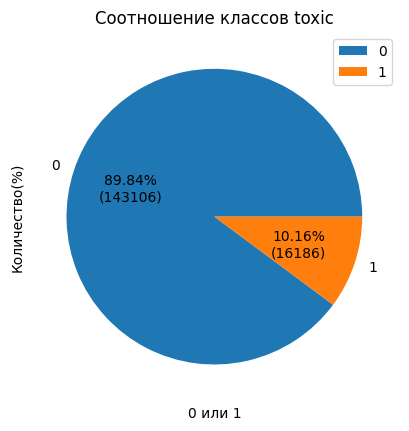

In [11]:
def how_percent_pie(x):
    next_step = next(step)
    return f'{x :.2f}%\n({pie_data[next_step]})'

step = iter([0, 1])
pie_data = data['toxic'].value_counts()
plt.pie(pie_data, labels=['0', '1'], autopct=how_percent_pie);
plt.legend();
plt.xlabel('0 или 1');
plt.ylabel('Количество(%)');
plt.title('Соотношение классов toxic');

*Требуется балансировка классов.*

<a id='my_section_5'></a>
#### [Вывод](#content_5)

Изучены данные, требуется провести:
1. предобработку текста(упрощение);
2. балансировку классов.


<a id='my_section_6'></a>
### [Упрощение текста](#content_6)

Проведём меры по подготовке и упрощению текста. Будем придерживаться алгоритма:

1. Токенизация каждого текста, то есть его разбиение на слова;
2. Лемматизация слов: приведение к начальной словарной форме (более сложные модели, например, BERT, этого не требуют: они сами понимают формы слов);
3. Очищение текста от стоп-слов и ненужных символов;
4. Для корректной работы алгоритма добавление маркеров начала и конца предложения (они приравниваются к токенам).
5. На выходе у каждого исходного текста образуется свой список токенов.


<a id='my_section_7'></a>
#### [Токенизация](#content_7)

In [12]:
def token_text(text):
    return nltk.tokenize\
           .sent_tokenize(text, language='english')

In [13]:
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(token_text) 

100%|███████████████████████████████████████████████████████████████████████| 159292/159292 [00:11<00:00, 13697.97it/s]


In [14]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,[Explanation\nWhy the edits made under my user...
1,D'aww! He matches this background colour I'm s...,0,"[D'aww!, He matches this background colour I'm..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[Hey man, I'm really not trying to edit war., ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[""\nMore\nI can't make any real suggestions on..."
4,"You, sir, are my hero. Any chance you remember...",0,"[You, sir, are my hero., Any chance you rememb..."


<a id='my_section_8'></a>
#### [Лемматизация](#content_8)

Для лемматизации слов в таблице с целью сокращения используемых ресурсов составим словарь. Словарь будет состоять из уникальных слов в наборе данных и соответствующих им лемм. 

**Подготовка**

Определим функции для помощи в лемматизации:
- clear_str — очистка от мешающих символов.


In [15]:
def clear_str(text):
    clear_text = []
    for el in text:
        clear_text.append(re.sub(r'[^a-zA-ZTt]', ' ', el).strip().lower())
    return clear_text    

Очистим текст

In [16]:
data['lemm_text'] = data['lemm_text'].progress_apply(clear_str)

100%|███████████████████████████████████████████████████████████████████████| 159292/159292 [00:03<00:00, 51652.53it/s]


In [17]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,[explanation why the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,"[d aww, he matches this background colour i m ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey man i m really not trying to edit war, i..."
3,"""\nMore\nI can't make any real suggestions on ...",0,[more i can t make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",0,"[you sir are my hero, any chance you remembe..."


Для ускорение процесса лемматизации выгоднее обработать одну строчку. Составим множество уникальных слов

In [18]:
def unique_words_indf(data_col):
    """Создание множества уникальных
    слов переданного столбца датасета,
    обработка его от возможных помех
    (' ', '\n', '', ',') и вывод списка слов"""
    
    unique_words_set = set()
    for i, keyword in enumerate(data_col):
        for txt in keyword:
            for word in txt.strip().split(' '):
                unique_words_set.add(word)

    unique_words_list = [x for x in unique_words_set if x != ' ' 
                         and x != '\n' and x != '' and x != ',']
    
    print(f'Длина получившегося списка: {len(unique_words_list)}')
    
    return unique_words_list               

In [19]:
unique_words_list = unique_words_indf(data['lemm_text'])

Длина получившегося списка: 168516


**Переход к лемматизации**

In [20]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    if word == 'gotta':
        print([word], nltk.pos_tag([word])[0][1][0].upper())
    
    
    return tag_dict.get(tag, wordnet.NOUN)

In [21]:
def for_lemmatization(unique_words_list):
    """функция токенизирует и лемматизирует,
    проверяет на исключения и возвращает
    словарь {'исходное слово':'лемма'}"""
    
    # Создаём словарь и список исключений
    words_dict = {}
    exception_words = ['gonna', 'gotta', 'wanna', 'gimme', 'lemme']
    # Проводим токенизацию
    for el in tqdm(unique_words_list):
        tokens = nltk.word_tokenize(el)
        # Если после токенизации длинна больше 1: ['can', 'not'] 
        if len(tokens) > 1:
            # Возврат сочетания 'can not'
            if el == 'cannot':
                result = ' '.join(tokens)      
            # Проверка в списке исключений,
            # если есть, то возврат исходного слова
            elif el in exception_words:
                result = el
            # Проверка исключений        
            else:
                raise Exception(f'I do not know what to do with this word '
                                f'Given: {el} '
                                f'After nltk.word_tokenize: {tokens}') 
        # Если 1 — лемматизация
        elif len(tokens) == 1:
            w = str(tokens[0])
            result = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        # Создание словаря из исходного слова или
        # его леммы.
        words_dict[el] = result
    
    return words_dict


In [22]:
%%time
lemmatizer = WordNetLemmatizer()
words_dict = for_lemmatization(unique_words_list)

100%|████████████████████████████████████████████████████████████████████████| 168516/168516 [02:15<00:00, 1246.80it/s]

CPU times: total: 2min 14s
Wall time: 2min 15s


Проведём лемматизацию строк. Определим функцию

In [23]:
def lemmatize_data(keyword):
    lemmas = ''
    for el in keyword:
        top = [w for w in el.split(' ') if w != '' and w != ' ']
        for word in top:
            if word in words_dict.keys():
                lemmas += words_dict[word] + ' '
                
            else:
                print(word,'!!!')
                pass

    return lemmas.strip()

In [24]:
%%time
data['lemm_text'] = data['lemm_text'].progress_apply(lemmatize_data)

100%|███████████████████████████████████████████████████████████████████████| 159292/159292 [00:04<00:00, 34436.26it/s]

CPU times: total: 4.64 s
Wall time: 4.63 s


<a id='my_section_9'></a>
#### [Частотный анализ](#content_9)

In [25]:
def get_mood_words(tox=0):
    """функция для выбора токсичных 
    или не токсичных корпусов текста"""
    text = []
    for el in data.loc[data['toxic'] == tox, 'lemm_text']:
        for word in el.split():
            text.append(word)
    return text        

In [26]:
def plot_param(fdist):
    """функция для получения параметров
    по оси x и по оси y из `FreqDist`
    для потсроения `plt.subplots`"""
    
    x_label = []
    y_label = []
    for key, val in enumerate(fdist):
        x_label.append(val)
        y_label.append(fdist[val])
        if key == 30:
            break
    return x_label, y_label

Запишем в списки слова, где в целевом списке есть пометка 0 или 1.

In [27]:
toxic_words = get_mood_words(tox=1)
simple_words = get_mood_words(tox=0)

Получим словари распределения слов

In [28]:
simple_words_freq = FreqDist(simple_words)
toxic_words_freq = FreqDist(toxic_words)

Получим параметры для построения графика распределения

In [29]:
simple_x_label, simple_y_label  = plot_param(simple_words_freq)
toxic_x_label, toxic_y_label  = plot_param(toxic_words_freq)

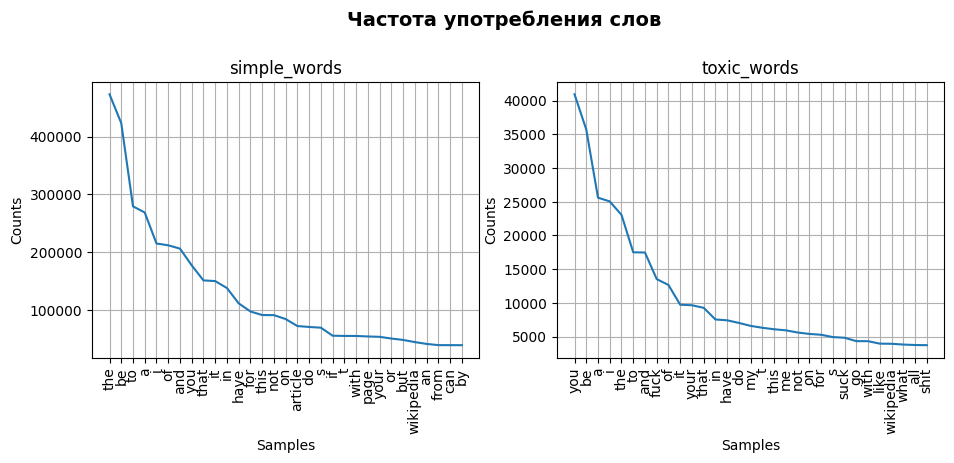

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))
fig.suptitle('Частота употребления слов', fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.8)

plot_param = {'simple_words': [simple_x_label, simple_y_label], 'toxic_words': [toxic_x_label, toxic_y_label]}
count = 0
for key, val in plot_param.items():
    ax[count].plot(val[0], val[1])
    ax[count].tick_params('x', labelrotation = 90)
    ax[count].grid()
    ax[count].set_ylabel('Counts')
    ax[count].set_xlabel('Samples')
    ax[count].set_title(key)
    count += 1

*Можно заметить, что в данный момент наибольшие частоты имеют союзы, предлоги и другие служебные части речи, не несущие смысловой нагрузки, а только выражающие семантико-синтаксические отношения между словами. Для того, чтобы результаты частотного анализа отражали тематику текста, необходимо удалить эти слова из текста.*

Произведём удаление от стоп-слов и оценим результат

In [31]:
english_stopwords = nltk_stopwords.words('english')
def del_stop_words(text):
    result = [word for word in text.split() if word
              not in english_stopwords]
        
    return ' '.join(result)

In [32]:
data['lemm_text'] = data['lemm_text'].progress_apply(del_stop_words)

100%|███████████████████████████████████████████████████████████████████████| 159292/159292 [00:10<00:00, 15473.27it/s]


Потсроим облако слов(`wordcloud`) для демонстрации 

In [33]:
toxic_words = ' '.join(get_mood_words(tox=1))
simple_words = ' '.join(get_mood_words(tox=0))

In [34]:
wordcloud_tox = WordCloud(collocations=False).generate(toxic_words)
wordcloud_sim = WordCloud(collocations=False).generate(simple_words)

**Токсичные слова**

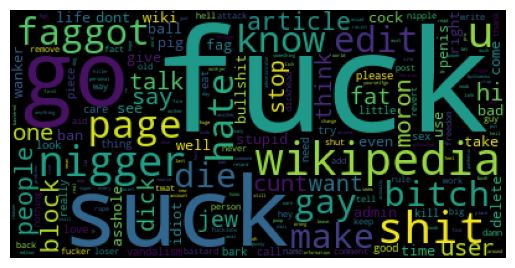

In [35]:
plt.imshow(wordcloud_tox)
plt.axis('off');

**Обычные слова**

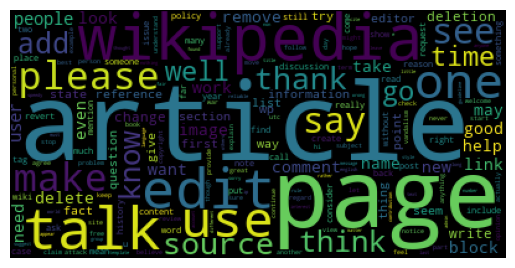

In [36]:
plt.imshow(wordcloud_sim)
plt.axis('off');

*Проведено избавление от стоп-слов, выражающих семантико-синтаксические отношения. В настоящий момент результаты частотного анализа отражает тематику текста или его эмоциональную окраску.*

<a id='my_section_10'></a>
### [Подготовка признаков](#content_10)

Разделим на обучающий и целевой признаки

In [37]:
features = data['lemm_text']
target = data['toxic']

<a id='my_section_11'></a>
#### [Разделение на выборки](#content_11)

Разобъём набор данных на выборки, проконтролируем результат.

Опередим функцию:
1. signs — для разделения на признаки и проверки их распределения;

In [38]:
def signs(features, target):
    def check_signs(train, valid, test):
        # Проверка соотношения между прзнаками
        dict_signs = {'обучающая':train, 'валидационная':valid, 'тестовая':test}
        print('Процентное соотношение выборок после разделения: ')
        # Создание словарей
        total_el_signs = {key:val.shape[0] for key, val in dict_signs.items()}
        percent_signs = {key:val/data.shape[0] for key, val in total_el_signs.items()}
        # Подведение итогов
        total_info = pd.DataFrame({'Количество': total_el_signs, 'Процент(%)': percent_signs})
        display(total_info)
    
    # Разделение на `train`, `valid`, `test`
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, random_state=12345, test_size=.4, stratify=target)

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, random_state=12345, test_size=.5, stratify=target_valid)
    
    # Разделение на 'X_train', 'y_train' для Pipline
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, random_state=12345, test_size=0.33, stratify=target)
    
    check_signs(features_train, features_valid, features_test)
    
    
    return features_train, target_train,\
            features_valid, target_valid,\
            features_test, target_test,\
            X_train, y_train,\
            X_test, y_test

Разделим на выборки

In [39]:
features_train, target_train,\
features_valid, target_valid,\
features_test, target_test,\
X_train, y_train,\
X_test, y_test = signs(features, target)

Процентное соотношение выборок после разделения: 


,Количество,Процент(%)
обучающая,95575,0.599999
валидационная,31858,0.199997
тестовая,31859,0.200004


*Разделение произведено, но стоит учитывать, что у нас баланс классов в целевом признаки нарушен, поэтому требуется провести ребалансировку.*

<a id='my_section_12'></a>
#### [Ребаланс/Upsampling](#content_12)

Проводить `upsampling` будем только для обучающей выборке.
Изучим во сколько раз классы отличаются.

In [40]:
ans = round(target_train.loc[target_train == 0].count()
     //target_train.loc[target_train == 1].count(), 3)
ans

8

*Используем это значение в unsample*

Определим функцию для балансировки классов

In [41]:
def upsample(features, target, repeat):
    features = pd.Series([el for el in features])
    target = target.reset_index(drop=True)

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [42]:
features_upsampled, target_upsampled = upsample(features_train, target_train, ans)

Оценим на сколько увеличилась выборка

In [43]:
def upsample_info():
    len_before = features_train.shape[0]
    len_after = len(features_upsampled)
    print(f"{(len_after-len_before)/len_before*100 :.2f}%")

upsample_info()

71.13%


*Данные подготовлены*

<a id='my_section_13'></a>
#### [TF_IDF](#content_13)

Очистим текст от `stop_words` и разметим его.

In [44]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
tf_idf_train = count_tf_idf.fit(features_upsampled)

In [45]:
tf_idf_train = count_tf_idf.transform(features_upsampled)
tf_idf_valid = count_tf_idf.transform(features_valid)
tf_idf_test = count_tf_idf.transform(features_test)

<a id='my_section_14'></a>
### [Заключение](#content_14)

Проведены следующие мероприятния:
1. загружены библиотеки и модули, набор данных;
2. проведено ознакомление с основными параметрами данных, выявлен дисбаланс классов;
3. упрощен текст, проведены
    - токенизация;
    - лемматизация.
4. данные разделены на выбоки;
5. произведен ребаланс классов техникой unsampling;
6. разбитые данные получили веторизацию TF_IDF.

Данные подготовлены для обучения моделей.

<a id='my_section_15'></a>
## [Обучение](#content_15)

Обучим разные модели и выберем лучшую

<a id='my_section_16'></a>
### [LogisticRegression](#content_16)

Рассмотрим для этой модели разные варианты гиперпараметров

<a id='my_section_17'></a>
#### [Upsample](#content_17)

In [46]:
model_lu = LogisticRegression(random_state=12345, solver='liblinear')
model_lu.fit(tf_idf_train, target_upsampled)
predicted_valid_lu = model_lu.predict(tf_idf_valid)

print("F1:", f1_score(target_valid, predicted_valid_lu))

F1: 0.7550133221147104


<a id='my_section_18'></a>
#### [Balanced](#content_18)

In [47]:
model_lb = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lb.fit(tf_idf_train, target_upsampled)
predicted_valid_lb = model_lb.predict(tf_idf_valid)

print("F1:", f1_score(target_valid, predicted_valid_lb))

F1: 0.7489677952105697


<a id='my_section_19'></a>
#### [GridSearchCV + Pipeline](#content_19)

Определим pipline, получим список параметров

In [48]:
pipe_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
                  ('clf', LogisticRegression(random_state=12345))])
pipe_lr.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(stop_words=["hadn't", 'when', "that'll", 'i', 'the', 'should',
                               'who', 'against', 'into', 'does', 'most', 'myself',
                               'm', 'there', 'over', 'why', 'where', 're', 'can',
                               'no', 'hasn', 'same', 'have', 'has', 'did', 'them',
                               'for', 'himself', "she's", 'our', ...])),
  ('clf', LogisticRegression(random_state=12345))],
 'verbose': False,
 'tfidf': TfidfVectorizer(stop_words=["hadn't", 'when', "that'll", 'i', 'the', 'should',
                             'who', 'against', 'into', 'does', 'most', 'myself',
                             'm', 'there', 'over', 'why', 'where', 're', 'can',
                             'no', 'hasn', 'same', 'have', 'has', 'did', 'them',
                             'for', 'himself', "she's", 'our', ...]),
 'clf': LogisticRegression(random_state=12345),
 'tfidf__analyzer': 'word',
 'tfidf__bi

Установим некоторые из них и передадим GridSearchCV

In [49]:
%%time
parametres_lr = {'clf__solver':['lbfgs', 'liblinear', 'newton-cg'],
                 'clf__max_iter':[5000],
                 'clf__C':[1, 10],
                 'clf__verbose': [1]}

grid_lr = GridSearchCV(estimator=pipe_lr,
                         param_grid=parametres_lr,
                         cv=5,
                         scoring=make_scorer(f1_score),
                         n_jobs=-1)

search_lr = grid_lr.fit(X_train, y_train)

CPU times: total: 7.83 s
Wall time: 42 s


Предскажем значение

Получим таблицу с параметрами всех моделей

In [50]:
lr_gridsearch = pd.DataFrame(grid_lr.cv_results_)
lr_gridsearch.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,param_clf__solver,param_clf__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.059723,0.225917,0.608571,0.04072,1,5000,lbfgs,1,"{'clf__C': 1, 'clf__max_iter': 5000, 'clf__sol...",0.720159,0.726407,0.716653,0.719323,0.722001,0.720909,0.003244,5


Получим лучшие параметры лучшей модели

In [51]:
grid_lr.best_params_

{'clf__C': 10,
 'clf__max_iter': 5000,
 'clf__solver': 'newton-cg',
 'clf__verbose': 1}

Получим её точность

In [52]:
f1_y_pred = search_lr.best_score_
print("F1:", f1_y_pred)

F1: 0.7662235157453029


<a id='my_section_20'></a>
### [CatBoostClassifier](#content_20)

In [53]:
%%time
best_f1 = 0.0001
for depth in tqdm(range(7,8)):
    for ite in range(100,300,200):
        model_cbc = CatBoostClassifier(iterations=ite, depth=depth, learning_rate=0.32)

        start_cb_fit = time.process_time()
        model_cbc.fit(tf_idf_train, target_upsampled, verbose=ite)
        finish_cb_fit = time.process_time() - start_cb_fit

        start_cb_predict = time.process_time()
        predictions_valid_cbc = model_cbc.predict(tf_idf_valid)
        finish_cb_predict = time.process_time() - start_cb_predict

        result_cbc = f1_score(target_valid, predictions_valid_cbc)
        if result_cbc >= best_f1:
            cbc_best_f1 = result_cbc
            cbc_best_f1_model = model_cbc
            cbc_best_iter = ite
            cbc_best_depth = depth
            cbc_fit = finish_cb_fit
            cbc_pred = finish_cb_predict

print(f'\nf1 лучшей модели: {cbc_best_f1}\n'
      f'Количество итераций: {cbc_best_iter}\n'
      f'Лучшая глубина: {cbc_best_depth}\n'
      f'Время обучения: {cbc_fit}\n'
      f'Время предсказания: {cbc_pred}\n')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0:	learn: 0.5659262	total: 1.29s	remaining: 2m 8s
99:	learn: 0.2385122	total: 1m 37s	remaining: 0us


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:45<00:00, 105.37s/it]


f1 лучшей модели: 0.7468408348715037
Количество итераций: 100
Лучшая глубина: 7
Время обучения: 496.546875
Время предсказания: 0.65625

CPU times: total: 8min 17s
Wall time: 1min 45s


<a id='my_section_21'></a>
#### [ GridSearchCV + Pipeline](#content_21)

In [54]:
pipe_cbc = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
                  ('cbc', CatBoostClassifier(learning_rate=0.32))])
pipe_cbc.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(stop_words=["hadn't", 'when', "that'll", 'i', 'the', 'should',
                               'who', 'against', 'into', 'does', 'most', 'myself',
                               'm', 'there', 'over', 'why', 'where', 're', 'can',
                               'no', 'hasn', 'same', 'have', 'has', 'did', 'them',
                               'for', 'himself', "she's", 'our', ...])),
  ('cbc', <catboost.core.CatBoostClassifier at 0x24d7ba8d790>)],
 'verbose': False,
 'tfidf': TfidfVectorizer(stop_words=["hadn't", 'when', "that'll", 'i', 'the', 'should',
                             'who', 'against', 'into', 'does', 'most', 'myself',
                             'm', 'there', 'over', 'why', 'where', 're', 'can',
                             'no', 'hasn', 'same', 'have', 'has', 'did', 'them',
                             'for', 'himself', "she's", 'our', ...]),
 'cbc': <catboost.core.CatBoostClassifier at 0x24d7ba8d790>,
 'tfidf__anal

In [55]:
%%time
parametres_cbc = {'cbc__iterations':[100, 300],
                 'cbc__depth':[7, 8]}

grid_cbc = GridSearchCV(estimator=pipe_cbc,
                         param_grid=parametres_cbc,
                         cv=3,
                         scoring=make_scorer(f1_score),
                         n_jobs=-1)

search_cbc = grid_cbc.fit(X_train, y_train)

0:	learn: 0.4176170	total: 1.86s	remaining: 9m 16s
1:	learn: 0.3076544	total: 3.64s	remaining: 9m 2s
2:	learn: 0.2596406	total: 5.44s	remaining: 8m 58s
3:	learn: 0.2331420	total: 7.22s	remaining: 8m 54s
4:	learn: 0.2203837	total: 8.96s	remaining: 8m 48s
5:	learn: 0.2121736	total: 10.7s	remaining: 8m 43s
6:	learn: 0.2066036	total: 12.4s	remaining: 8m 39s
7:	learn: 0.2005435	total: 14.2s	remaining: 8m 36s
8:	learn: 0.1971192	total: 15.9s	remaining: 8m 33s
9:	learn: 0.1932858	total: 17.6s	remaining: 8m 30s
10:	learn: 0.1904011	total: 19.4s	remaining: 8m 28s
11:	learn: 0.1858928	total: 21.2s	remaining: 8m 28s
12:	learn: 0.1833425	total: 23s	remaining: 8m 27s
13:	learn: 0.1809650	total: 24.7s	remaining: 8m 24s
14:	learn: 0.1792405	total: 26.4s	remaining: 8m 22s
15:	learn: 0.1773080	total: 28.2s	remaining: 8m 19s
16:	learn: 0.1756154	total: 29.9s	remaining: 8m 17s
17:	learn: 0.1734462	total: 31.6s	remaining: 8m 15s
18:	learn: 0.1713900	total: 33.4s	remaining: 8m 13s
19:	learn: 0.1695055	tota

Получим лучшие параметры модели

In [56]:
grid_cbc.best_params_

{'cbc__depth': 8, 'cbc__iterations': 300}

Получим её точность

In [57]:
f1_y_pred = search_cbc.best_score_
print("F1:", f1_y_pred)

F1: 0.7510363407178146


<a id='my_section_22'></a>
### [Заключение](#content_22)

В ходе эксперимента модели показали следующие значения метрики f1:
- LogisticRegression(указаны разные способы балансирования класса):
    - Upsample — 0.7515383563517024;
    - Balanced — 0.7458630431857931;
    - GridSearchCV + Pipeline — 0.7662235157453029.
    
- CatBoostClassifier — 0.7468408348715037;
    - GridSearchCV + Pipeline — 0.7261040600781233.

В результате была выбрана модель `LogisticRegression`(f1: 0.7662) для изучения на тестовой выборке.

<a id='my_section_23'></a>
## [Тестирование](#content_23)

In [58]:
test_predict_lr = search_lr.best_estimator_.predict(X_test)
test_f1_score_lr = f1_score(y_test, test_predict_lr)
print(f'Тестирование лучшей модели LogisticRegression показало точность: {test_f1_score_lr}')

Тестирование лучшей модели LogisticRegression показало точность: 0.768858495528669


<a id='my_section_24'></a>
## [Выводы](#content_24)

В проекте проведен ряд мер по подготовке данных и их применению:
1. В процессе подготовки данных:    
    - Загружены модули и библиотеки, набор данных;
    - Произведён первичный анализ, выявлено, что целевой признак несбалансирован;
    - упрощен текст, проведены:
        - токенизация;
        - лемматизация.
    - данные разделены на выбоки;
    - произведен ребаланс классов техникой unsampling;
    - разбитые данные получили веторизацию TF_IDF.
    
2. Для обучения были выбраны разные модели, они показали точность:
    - LogisticRegression(разное балансирование):
        - Upsample (0.7550133221147104);
        - Balanced (0.7489677952105697);
        - GridSearchCV+Pipeline (0.7662235157453029).
    - CatBoostClassifier (0.7468408348715037);
        - GridSearchCV+Pipeline (0.7261040600781233).
    
3. Проведено тестирование выбранной модели(LogisticRegression(GridSearchCV+Pipeline), показавшей значение метрики f1:
    - 0.768858495528669.
    
Обучена модель для классификации комментариев на позитивные и негативные. Точность модели удовлетворяет критерию заказчика.    

